# Práctica 3: Redes neuronales convolucionales para clasificación de imágenes histopatológicas

En esta práctica, vamos a utilizar modelos profundos para clasificar imágenes histopatológicas de muestras de cancer colorectal. En este caso, utilizaremos el dataset PathMNIST de MedMNISTv2, que contiene imágenes histopatológicas de tamaño reducido (28x28, con 3 canales de color RGB), correspondientes a 9 clases diferentes de tejidos. 

Las posibles clases son:

* '0': 'adipose'
* '1': 'background'
* '2': 'debris'
* '3': 'lymphocytes'
* '4': 'mucus'
* '5': 'smooth muscle'
* '6': 'normal colon mucosa'
* '7': 'cancer-associated stroma'
* '8': 'colorectal adenocarcinoma epithelium'

Para más información sobre MedMNISTv2 y el dataset utilizado, ver el paper asociado ( https://arxiv.org/pdf/2110.14795.pdf ) o el sitio web del proyecto: https://medmnist.com/

Vamos a comenzar por descargar y visualizar el dataset:

In [1]:
!pip install medmnist

In [2]:
import warnings

import matplotlib.pyplot as plt
import medmnist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO, Evaluator
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

torch.manual_seed(10)  # set seed for reproducibility
np.random.seed(10)

data_flag = "pathmnist"
download = True

info = INFO[data_flag]
task = info["task"]
n_channels = info["n_channels"]
n_classes = len(info["label"])

DataClass = getattr(medmnist, info["python_class"])

# Creando los datasets
Ahora procederemos a crear los datasets con las imágenes de training y de test. Aquí por simplicidad no utilizaremos la partición de validación, pero recordar que siempre se debe contar con una partición de validación para la selección de hiperparámetros y de modelo.

In [3]:
# Tamaño del batch de entrenamiento que será utilizado al generar los dataloaders
BATCH_SIZE = 128

# Transformaciones que serán utilizadas para normalizar las imagenes
data_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
)

# Creo los datasets
train_dataset = DataClass(split="train", transform=data_transform, download=download)
test_dataset = DataClass(split="test", transform=data_transform, download=download)

# Dataset que será utilizado solo para vbisualización (no incluye las transformaciones)
visual_dataset = DataClass(split="train", download=download)

# Encapsulo los datasets en un dataloader
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)

Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/pathmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/pathmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/pathmnist.npz


# Visualizando las imágenes

Labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


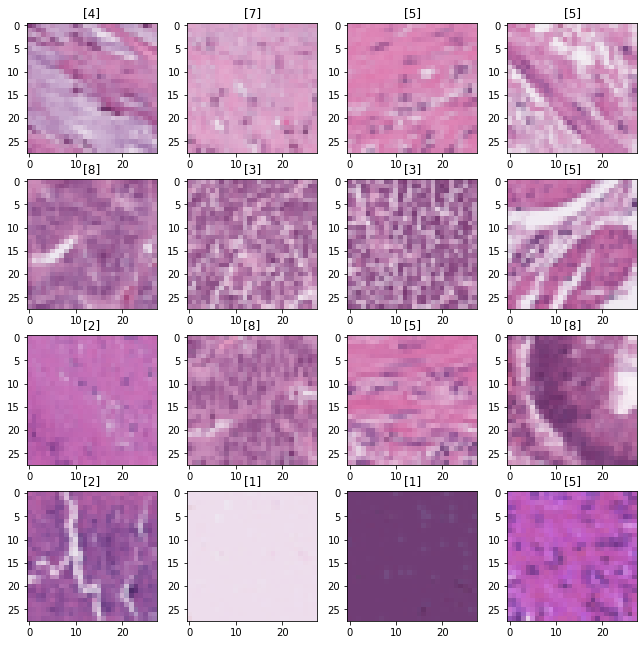

In [4]:
# Visualizamos algunas imágenes de ejemplo con sus etiquetas
offset = 0
plt.rcParams["figure.figsize"] = [11, 11]

for i in range(1 + offset, 17 + offset):
    plt.subplot(4, 4, i - offset)
    img = visual_dataset[i][0]
    lbl = visual_dataset[i][1]
    plt.imshow(img)
    plt.title(lbl)

print("Labels: " + str(train_dataset.info["label"]))

# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 9 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28 x 3, a un vector de 2352 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 9 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


class NetMLP(torch.nn.Module):
    def __init__(self, input_features=28 * 28 * 3, size_hidden=15, n_output=9):
        super().__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        # x: batch_size x 3 x 28 x 28
        x = x.view(x.size(0), -1)  # batch_size x 2352
        x = self.hidden1(x)  # batch_size x size_hidden
        x = F.relu(x)  # batch_size x size_hidden
        x = self.hidden2(x)  # batch_size x size_hidden
        x = F.relu(x)  # batch_size x size_hidden
        x = self.out(x)  # batch_size x n_output
        return x

Y ahora entrenamos el modelo

In [6]:
def trainer(
    net,
    train_loader,
    test_loader,
    *,
    num_epochs,
    input_features=28 * 28 * 3,
    learning_rate=0.001
):
    # Construimos el optimizador, y le indicamos que los parámetros a optimizar
    # son los del modelo definido: net.parameters()

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Definimos también la función de pérdida a utilizar
    criterion = nn.CrossEntropyLoss()

    # Creamos un loader iterable indicandole que debe leer los datos a partir de
    # del dataset creado en el paso anterior. Este objeto puede ser iterado
    # y nos devuelve de a un batch (x, y).

    # Lista en la que iremos guardando el valor de la función de pérdida en cada
    # etapa de entrenamiento
    loss_list = []

    acc_list = []
    acc_test_list = []
    iter_test_loader = iter(test_loader)

    # Bucle de entrenamiento
    for i in range(num_epochs):
        print("Epoch : " + str(i))
        loss_list_epoch = []
        # Itero sobre todos los batches del dataset
        for x, y in tqdm(train_loader):
            # Seteo en cero los gradientes de los parámetros a optimizar
            optimizer.zero_grad()

            # Movemos los tensores a memoria de GPU
            x = x.to(device)
            y = y.to(device)
            y = y.squeeze().long()
            pred = net(x)

            # Realizo la pasada forward por la red
            loss = criterion(pred, y)

            # Realizo la pasada backward por la red
            loss.backward()

            # Actualizo los pesos de la red con el optimizador
            optimizer.step()

            # Acc
            with torch.no_grad():
                acc = (pred.argmax(dim=1) == y).sum() / y.size(0)
                try:
                    x_val, y_val = next(iter_test_loader)
                except StopIteration:
                    iter_test_loader = iter(test_loader)
                    x_val, y_val = next(iter_test_loader)

                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val.squeeze().long()
                pred_val = net(x_val)
                acc_val = (pred_val.argmax(dim=1) == y_val).sum() / y_val.size(0)

            # Me guardo el valor actual de la función de pérdida para luego graficarlo
            loss_list.append(loss.data.item())
            loss_list_epoch.append(loss.data.item())
            acc_list.append(acc.data.item())
            acc_test_list.append(acc_val.data.item())
        # Muestro el valor de la función de pérdida cada 100 iteraciones
        # if i > 0 and i % 100 == 0:
        print(
            "Epoch %d, Avg train loss during epoch = %g"
            % (i, np.array(loss_list_epoch).mean())
        )
    return loss_list, acc_list, acc_test_list


def plot_loss(loss_list, ax):
    # Muestro la lista que contiene los valores de la función de pérdida
    # y una versión suavizada (rojo) para observar la tendencia
    loss_np_array = np.array(loss_list)
    ax.plot(loss_np_array, alpha=0.3, label="loss")
    N = 60
    running_avg_loss = np.convolve(loss_np_array, np.ones((N,)) / N, mode="valid")
    ax.plot(running_avg_loss, color="red", label="loss suavizada")
    ax.set_title("Función de pérdida durante el entrenamiento")
    ax.legend()


def plot_acc(acc_list, acc_test_list, ax):
    acc_np_array = np.array(acc_list)
    ax.plot(acc_np_array, alpha=0.3, color="red", label="acc_train")
    N = 60
    running_avg_loss = np.convolve(acc_np_array, np.ones((N,)) / N, mode="valid")
    ax.plot(running_avg_loss, color="red", label="acc_train suavizada")

    acc_test_np_array = np.array(acc_test_list)
    ax.plot(acc_test_np_array, alpha=0.3, color="blue", label="acc_test")
    N = 60
    running_test_avg_loss = np.convolve(
        acc_test_np_array, np.ones((N,)) / N, mode="valid"
    )
    ax.plot(running_test_avg_loss, color="blue", label="acc_test suavizada")
    ax.set_title("Accuracy durante el entrenamiento")
    ax.legend()

In [7]:
# Numero de epocas de entrenamiento
num_epochs = 5

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetMLP()
net.to(device)
loss_list, acc_list, acc_test_list = trainer(
    net,
    train_loader,
    test_loader,
    num_epochs=num_epochs,
)

Epoch : 0


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.82it/s]


Epoch 0, Avg train loss during epoch = 1.64321
Epoch : 1


100%|████████████████████████████████████████| 704/704 [00:31<00:00, 22.06it/s]


Epoch 1, Avg train loss during epoch = 1.43731
Epoch : 2


100%|████████████████████████████████████████| 704/704 [00:31<00:00, 22.07it/s]


Epoch 2, Avg train loss during epoch = 1.29476
Epoch : 3


100%|████████████████████████████████████████| 704/704 [00:31<00:00, 22.10it/s]


Epoch 3, Avg train loss during epoch = 1.25007
Epoch : 4


100%|████████████████████████████████████████| 704/704 [00:31<00:00, 22.01it/s]

Epoch 4, Avg train loss during epoch = 1.21388


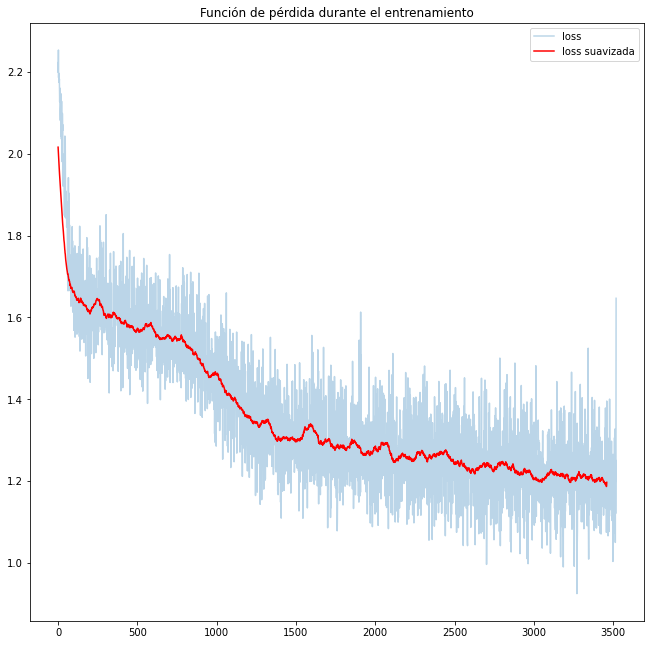

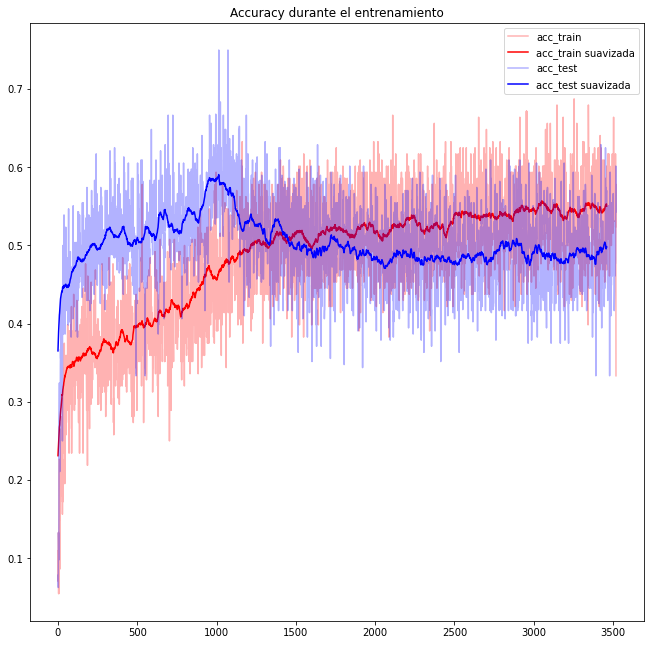

In [8]:
fig_loss_mpl, ax = plt.subplots()
plot_loss(loss_list, ax)

fig_acc_mpl, ax = plt.subplots()
plot_acc(acc_list, acc_test_list, ax)

### Guardamos el modelo para poder reutilizarlo

In [9]:
torch.save(net.state_dict(), "./mlp.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [10]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
net = NetMLP()
net.load_state_dict(torch.load("./mlp.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=2352, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=9, bias=True)
)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        62
           1       0.57      0.74      0.65        27
           2       0.19      0.25      0.21        12
           3       0.29      0.17      0.21        24
           4       0.63      0.60      0.62        40
           5       0.17      0.36      0.23        14
           6       0.33      0.05      0.09        20
           7       0.00      0.00      0.00        15
           8       0.59      0.79      0.67        42

    accuracy                           0.57       256
   macro avg       0.41      0.43      0.40       256
weighted avg       0.56      0.57      0.55       256



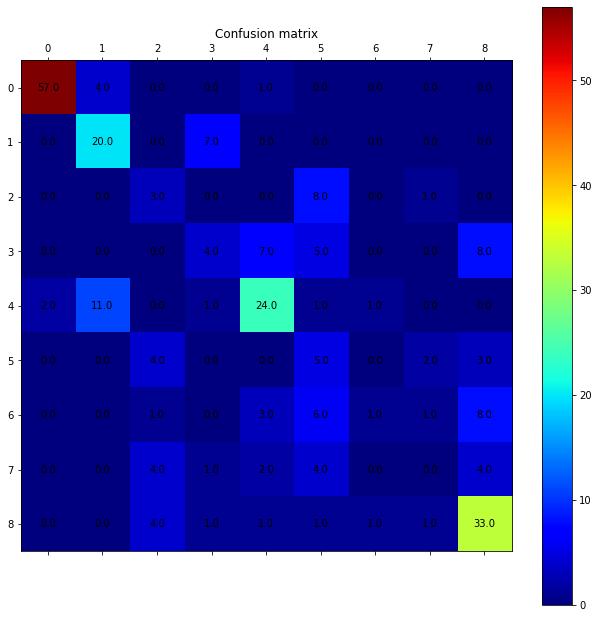

In [11]:
def showTestResults(model, ax):
    plt.rcParams["figure.figsize"] = [12, 10]
    from sklearn.metrics import (
        ConfusionMatrixDisplay,
        classification_report,
        confusion_matrix,
    )

    # Genero un data loader para leer los datos de test
    x_test = list(test_loader)[0][0]
    y_test = list(test_loader)[0][1]

    # Muevo los tensores a la GPU
    x_test = x_test.to(device)

    # Realizo las predicciones del modelo
    pred = model(x_test)

    # Extraigo el índice de la predicción con mayor valor para decidir la clase asignada
    pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

    # Imprimo el reporte de clasificación (accuracy, etc)
    print(classification_report(y_test, pred_y))

    # Computo la matriz de confusión y la muestro
    conf_mat = confusion_matrix(y_test, pred_y)
    mat_plot = ax.matshow(conf_mat, cmap="jet")

    for (i, j), z in np.ndenumerate(conf_mat):
        ax.text(j, i, "{:0.1f}".format(z), ha="center", va="center")

    ax.set_title("Confusion matrix")
    plt.colorbar(mat_plot, ax=ax)


fig_conf_matr_mlp, ax = plt.subplots()
showTestResults(net, ax)

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (6 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa convolucional (16 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa totalmente conectada (120 neuronas) + ReLU
* Capa totalmente conectada (84 neuronas) + ReLU
* Capa de salida (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [12]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)  # batch_size x 6 x 28 x 28
        x = F.relu(x)  # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 6 x 14 x 14
        x = self.conv2(x)  # batch_size x 16 x 14 x14
        x = F.relu(x)  # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 16 x 7 x 7
        x = x.view(x.size(0), -1)  # batch_size x 16*7*7
        x = self.fc1(x)  # batch_size x 120
        x = self.fc2(x)  # batch_size x 84
        x = self.fc3(x)  # batch_size x 9
        return x

In [13]:
# Numero de epocas de entrenamiento
num_epochs = 5

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN()
net.to(device)

loss_list, acc_list, acc_test_list = trainer(
    net,
    train_loader,
    test_loader,
    num_epochs=num_epochs,
)

Epoch : 0


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.13it/s]


Epoch 0, Avg train loss during epoch = 1.07874
Epoch : 1


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.83it/s]


Epoch 1, Avg train loss during epoch = 0.744935
Epoch : 2


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.00it/s]


Epoch 2, Avg train loss during epoch = 0.650278
Epoch : 3


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.05it/s]


Epoch 3, Avg train loss during epoch = 0.593656
Epoch : 4


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.95it/s]

Epoch 4, Avg train loss during epoch = 0.557054


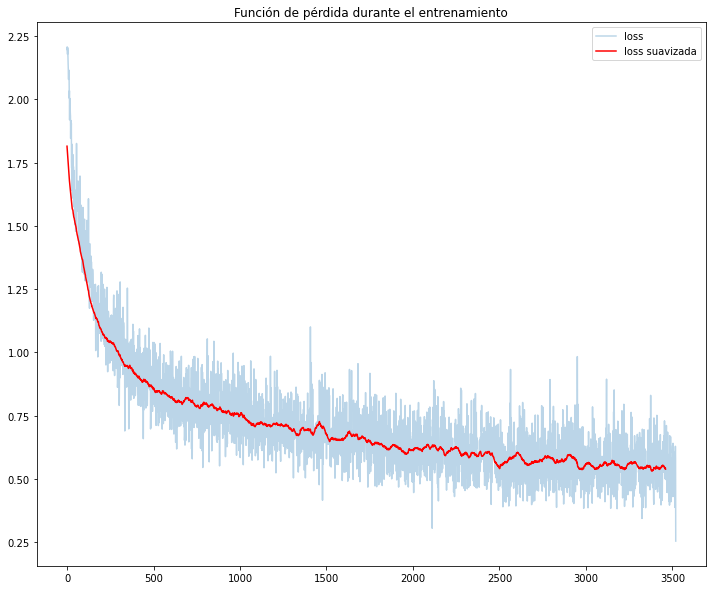

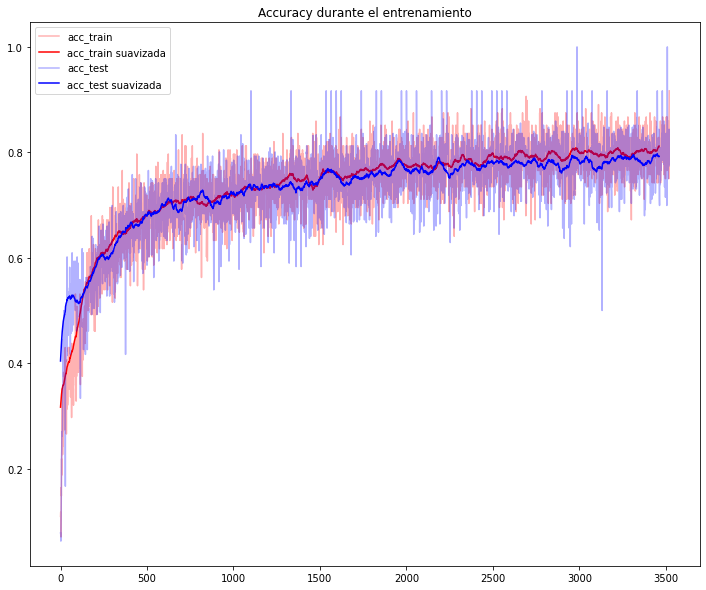

In [14]:
fig_loss_cnn, ax = plt.subplots()
plot_loss(loss_list, ax)

fig_acc_cnn, ax = plt.subplots()
plot_acc(acc_list, acc_test_list, ax)

### Guardo el modelo

In [15]:
torch.save(net.state_dict(), "./cnn.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [16]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.87      1.00      0.93        27
           2       0.42      0.67      0.52        12
           3       0.90      0.79      0.84        24
           4       0.97      0.82      0.89        40
           5       0.64      0.64      0.64        14
           6       0.62      0.65      0.63        20
           7       0.47      0.47      0.47        15
           8       0.89      0.81      0.85        42

    accuracy                           0.83       256
   macro avg       0.75      0.76      0.75       256
weighted avg       0.84      0.83      0.83       256



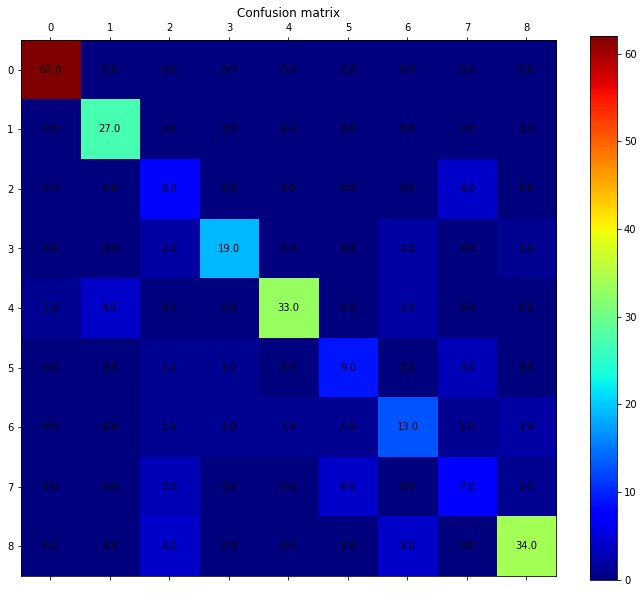

In [17]:
# Mostramos los resultados
fig_conf_matr_cnn, ax = plt.subplots()
showTestResults(net, ax)

# Entrenamiento por varias epocas
Se plantea entrenar el modelo por una gran cantidad de epocas e ir viendo como evoluciona la accuracy en train y test.

### MLP

In [18]:
# Numero de epocas de entrenamiento
num_epochs = 50

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetMLP()
net.to(device)

loss_list, acc_list, acc_test_list = trainer(
    net,
    train_loader,
    test_loader,
    num_epochs=num_epochs,
)

Epoch : 0


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.91it/s]


Epoch 0, Avg train loss during epoch = 1.61437
Epoch : 1


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 22.00it/s]


Epoch 1, Avg train loss during epoch = 1.32716
Epoch : 2


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.78it/s]


Epoch 2, Avg train loss during epoch = 1.23408
Epoch : 3


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.78it/s]


Epoch 3, Avg train loss during epoch = 1.18801
Epoch : 4


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.85it/s]


Epoch 4, Avg train loss during epoch = 1.15809
Epoch : 5


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.80it/s]


Epoch 5, Avg train loss during epoch = 1.13213
Epoch : 6


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.73it/s]


Epoch 6, Avg train loss during epoch = 1.11281
Epoch : 7


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.64it/s]


Epoch 7, Avg train loss during epoch = 1.09277
Epoch : 8


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.91it/s]


Epoch 8, Avg train loss during epoch = 1.07391
Epoch : 9


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.99it/s]


Epoch 9, Avg train loss during epoch = 1.05855
Epoch : 10


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.91it/s]


Epoch 10, Avg train loss during epoch = 1.04457
Epoch : 11


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.88it/s]


Epoch 11, Avg train loss during epoch = 1.02706
Epoch : 12


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.76it/s]


Epoch 12, Avg train loss during epoch = 1.01406
Epoch : 13


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.75it/s]


Epoch 13, Avg train loss during epoch = 1.00008
Epoch : 14


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.61it/s]


Epoch 14, Avg train loss during epoch = 0.987675
Epoch : 15


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.78it/s]


Epoch 15, Avg train loss during epoch = 0.974197
Epoch : 16


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.80it/s]


Epoch 16, Avg train loss during epoch = 0.961436
Epoch : 17


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.66it/s]


Epoch 17, Avg train loss during epoch = 0.953579
Epoch : 18


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.66it/s]


Epoch 18, Avg train loss during epoch = 0.945281
Epoch : 19


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.60it/s]


Epoch 19, Avg train loss during epoch = 0.933343
Epoch : 20


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.63it/s]


Epoch 20, Avg train loss during epoch = 0.927065
Epoch : 21


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.63it/s]


Epoch 21, Avg train loss during epoch = 0.917385
Epoch : 22


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.80it/s]


Epoch 22, Avg train loss during epoch = 0.91383
Epoch : 23


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.68it/s]


Epoch 23, Avg train loss during epoch = 0.902442
Epoch : 24


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.73it/s]


Epoch 24, Avg train loss during epoch = 0.903774
Epoch : 25


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.73it/s]


Epoch 25, Avg train loss during epoch = 0.899337
Epoch : 26


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.83it/s]


Epoch 26, Avg train loss during epoch = 0.89515
Epoch : 27


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.87it/s]


Epoch 27, Avg train loss during epoch = 0.88763
Epoch : 28


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.75it/s]


Epoch 28, Avg train loss during epoch = 0.884407
Epoch : 29


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.82it/s]


Epoch 29, Avg train loss during epoch = 0.879224
Epoch : 30


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.70it/s]


Epoch 30, Avg train loss during epoch = 0.876836
Epoch : 31


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.68it/s]


Epoch 31, Avg train loss during epoch = 0.874532
Epoch : 32


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.74it/s]


Epoch 32, Avg train loss during epoch = 0.871652
Epoch : 33


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.79it/s]


Epoch 33, Avg train loss during epoch = 0.868418
Epoch : 34


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.71it/s]


Epoch 34, Avg train loss during epoch = 0.864801
Epoch : 35


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.63it/s]


Epoch 35, Avg train loss during epoch = 0.858015
Epoch : 36


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.73it/s]


Epoch 36, Avg train loss during epoch = 0.857391
Epoch : 37


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.48it/s]


Epoch 37, Avg train loss during epoch = 0.855044
Epoch : 38


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.29it/s]


Epoch 38, Avg train loss during epoch = 0.850467
Epoch : 39


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.46it/s]


Epoch 39, Avg train loss during epoch = 0.84964
Epoch : 40


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.65it/s]


Epoch 40, Avg train loss during epoch = 0.848885
Epoch : 41


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.53it/s]


Epoch 41, Avg train loss during epoch = 0.845155
Epoch : 42


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.63it/s]


Epoch 42, Avg train loss during epoch = 0.843395
Epoch : 43


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.86it/s]


Epoch 43, Avg train loss during epoch = 0.84428
Epoch : 44


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.48it/s]


Epoch 44, Avg train loss during epoch = 0.841717
Epoch : 45


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.73it/s]


Epoch 45, Avg train loss during epoch = 0.833052
Epoch : 46


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.67it/s]


Epoch 46, Avg train loss during epoch = 0.834062
Epoch : 47


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.54it/s]


Epoch 47, Avg train loss during epoch = 0.833925
Epoch : 48


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.64it/s]


Epoch 48, Avg train loss during epoch = 0.831312
Epoch : 49


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.67it/s]

Epoch 49, Avg train loss during epoch = 0.829195


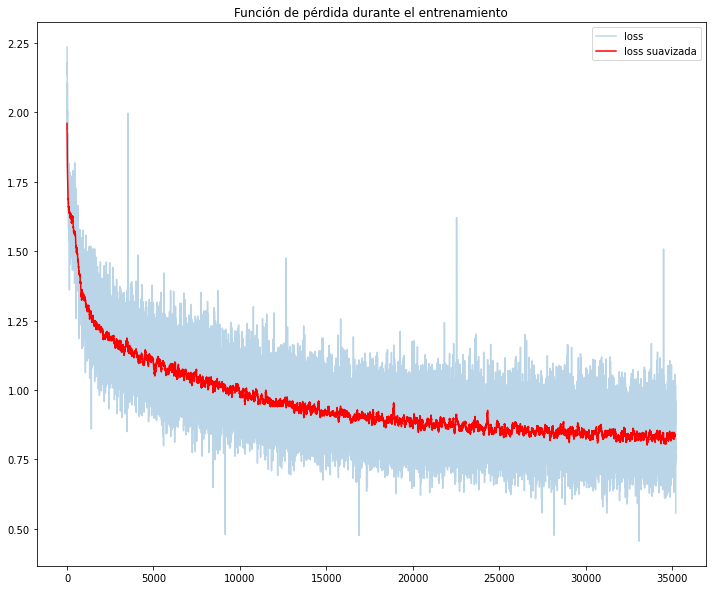

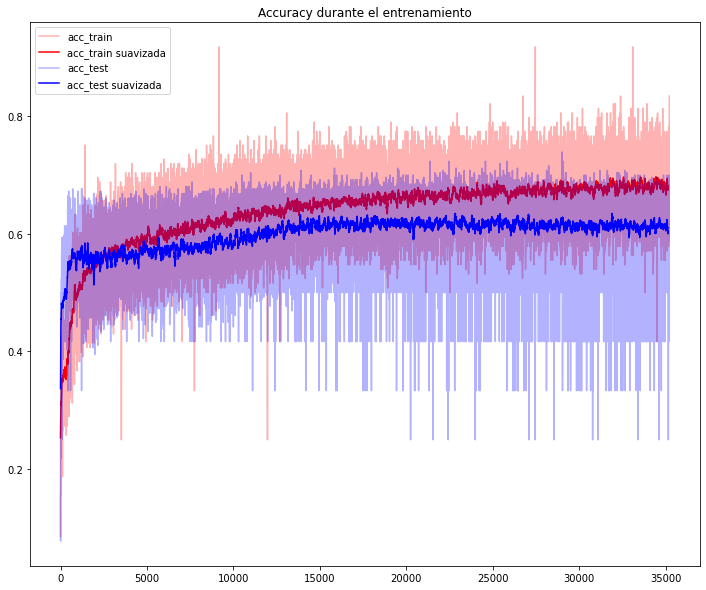

In [19]:
fig_loss_mlp_epochs, ax = plt.subplots()
plot_loss(loss_list, ax)

fig_acc_mlp_epochs, ax = plt.subplots()
plot_acc(acc_list, acc_test_list, ax)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        62
           1       0.64      1.00      0.78        27
           2       0.26      0.58      0.36        12
           3       0.90      0.38      0.53        24
           4       0.85      0.57      0.69        40
           5       0.50      0.57      0.53        14
           6       0.21      0.20      0.21        20
           7       0.36      0.27      0.31        15
           8       0.61      0.67      0.64        42

    accuracy                           0.65       256
   macro avg       0.59      0.57      0.55       256
weighted avg       0.70      0.65      0.65       256



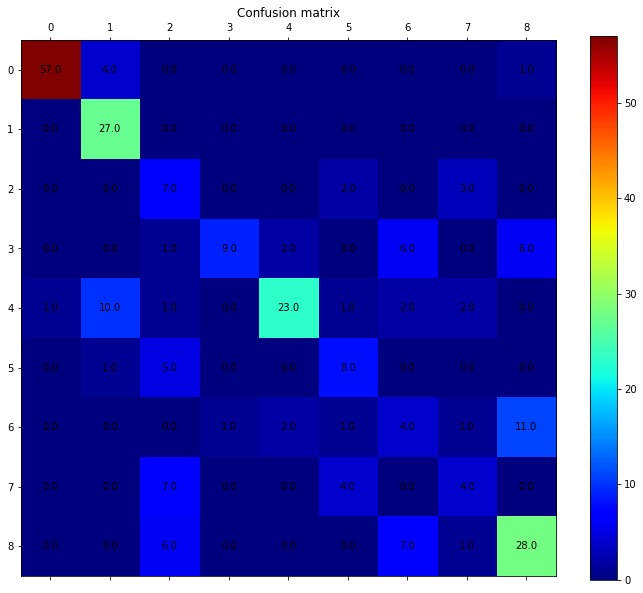

In [20]:
# Mostramos los resultados
fig_conf_matr_mlp_epochs, ax = plt.subplots()
showTestResults(net, ax)

### CNN

In [21]:
# Numero de epocas de entrenamiento
num_epochs = 50

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN()
net.to(device)

loss_list, acc_list, acc_test_list = trainer(
    net,
    train_loader,
    test_loader,
    num_epochs=num_epochs,
)

Epoch : 0


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.87it/s]


Epoch 0, Avg train loss during epoch = 1.00326
Epoch : 1


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.90it/s]


Epoch 1, Avg train loss during epoch = 0.757219
Epoch : 2


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.79it/s]


Epoch 2, Avg train loss during epoch = 0.647096
Epoch : 3


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.92it/s]


Epoch 3, Avg train loss during epoch = 0.58715
Epoch : 4


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.72it/s]


Epoch 4, Avg train loss during epoch = 0.556015
Epoch : 5


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.96it/s]


Epoch 5, Avg train loss during epoch = 0.526681
Epoch : 6


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.90it/s]


Epoch 6, Avg train loss during epoch = 0.511889
Epoch : 7


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.91it/s]


Epoch 7, Avg train loss during epoch = 0.495838
Epoch : 8


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.98it/s]


Epoch 8, Avg train loss during epoch = 0.485553
Epoch : 9


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.12it/s]


Epoch 9, Avg train loss during epoch = 0.477956
Epoch : 10


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.02it/s]


Epoch 10, Avg train loss during epoch = 0.464494
Epoch : 11


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.28it/s]


Epoch 11, Avg train loss during epoch = 0.455212
Epoch : 12


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.00it/s]


Epoch 12, Avg train loss during epoch = 0.451533
Epoch : 13


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.97it/s]


Epoch 13, Avg train loss during epoch = 0.440208
Epoch : 14


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.05it/s]


Epoch 14, Avg train loss during epoch = 0.430235
Epoch : 15


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.89it/s]


Epoch 15, Avg train loss during epoch = 0.428785
Epoch : 16


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.07it/s]


Epoch 16, Avg train loss during epoch = 0.424989
Epoch : 17


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.98it/s]


Epoch 17, Avg train loss during epoch = 0.413098
Epoch : 18


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.01it/s]


Epoch 18, Avg train loss during epoch = 0.40707
Epoch : 19


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.99it/s]


Epoch 19, Avg train loss during epoch = 0.402236
Epoch : 20


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.95it/s]


Epoch 20, Avg train loss during epoch = 0.39588
Epoch : 21


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.13it/s]


Epoch 21, Avg train loss during epoch = 0.390064
Epoch : 22


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.93it/s]


Epoch 22, Avg train loss during epoch = 0.388509
Epoch : 23


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.96it/s]


Epoch 23, Avg train loss during epoch = 0.375726
Epoch : 24


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.91it/s]


Epoch 24, Avg train loss during epoch = 0.381625
Epoch : 25


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.92it/s]


Epoch 25, Avg train loss during epoch = 0.368703
Epoch : 26


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.15it/s]


Epoch 26, Avg train loss during epoch = 0.364817
Epoch : 27


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.00it/s]


Epoch 27, Avg train loss during epoch = 0.360871
Epoch : 28


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.89it/s]


Epoch 28, Avg train loss during epoch = 0.361168
Epoch : 29


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.00it/s]


Epoch 29, Avg train loss during epoch = 0.358616
Epoch : 30


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.98it/s]


Epoch 30, Avg train loss during epoch = 0.353804
Epoch : 31


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.04it/s]


Epoch 31, Avg train loss during epoch = 0.352495
Epoch : 32


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.07it/s]


Epoch 32, Avg train loss during epoch = 0.349156
Epoch : 33


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.09it/s]


Epoch 33, Avg train loss during epoch = 0.348363
Epoch : 34


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.97it/s]


Epoch 34, Avg train loss during epoch = 0.345052
Epoch : 35


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.96it/s]


Epoch 35, Avg train loss during epoch = 0.343667
Epoch : 36


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.95it/s]


Epoch 36, Avg train loss during epoch = 0.338498
Epoch : 37


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.00it/s]


Epoch 37, Avg train loss during epoch = 0.340334
Epoch : 38


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 20.94it/s]


Epoch 38, Avg train loss during epoch = 0.334096
Epoch : 39


100%|████████████████████████████████████████| 704/704 [00:36<00:00, 19.12it/s]


Epoch 39, Avg train loss during epoch = 0.33428
Epoch : 40


100%|████████████████████████████████████████| 704/704 [00:47<00:00, 14.84it/s]


Epoch 40, Avg train loss during epoch = 0.332238
Epoch : 41


100%|████████████████████████████████████████| 704/704 [00:39<00:00, 17.94it/s]


Epoch 41, Avg train loss during epoch = 0.333507
Epoch : 42


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.18it/s]


Epoch 42, Avg train loss during epoch = 0.327299
Epoch : 43


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.11it/s]


Epoch 43, Avg train loss during epoch = 0.323457
Epoch : 44


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.15it/s]


Epoch 44, Avg train loss during epoch = 0.325684
Epoch : 45


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.10it/s]


Epoch 45, Avg train loss during epoch = 0.322189
Epoch : 46


100%|████████████████████████████████████████| 704/704 [00:32<00:00, 21.34it/s]


Epoch 46, Avg train loss during epoch = 0.322432
Epoch : 47


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.31it/s]


Epoch 47, Avg train loss during epoch = 0.318261
Epoch : 48


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.11it/s]


Epoch 48, Avg train loss during epoch = 0.321258
Epoch : 49


100%|████████████████████████████████████████| 704/704 [00:33<00:00, 21.18it/s]

Epoch 49, Avg train loss during epoch = 0.316902


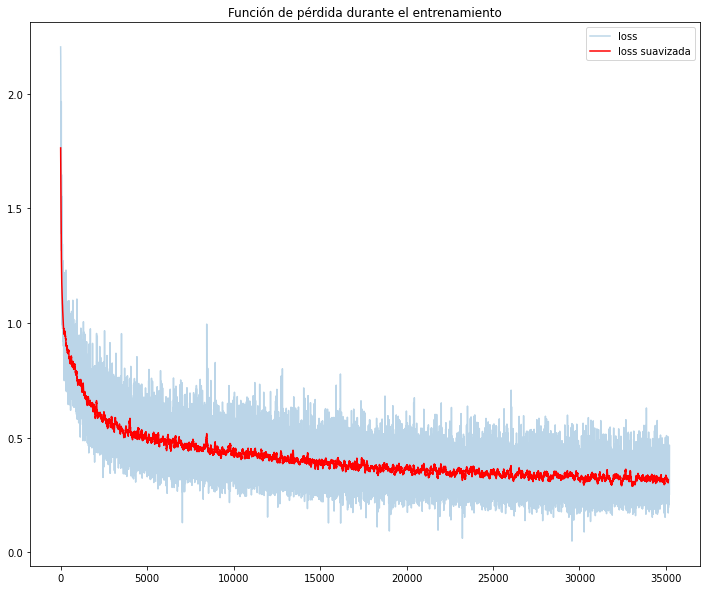

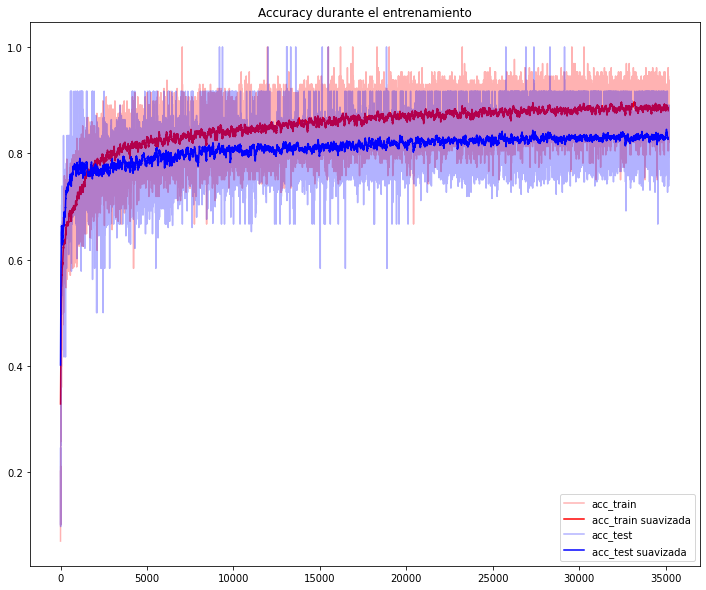

In [22]:
fig_loss_cnn_epochs, ax = plt.subplots()
plot_loss(loss_list, ax)

fig_acc_cnn_epochs, ax = plt.subplots()
plot_acc(acc_list, acc_test_list, ax)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        62
           1       0.96      1.00      0.98        27
           2       0.50      0.67      0.57        12
           3       0.86      1.00      0.92        24
           4       0.94      0.78      0.85        40
           5       0.62      0.71      0.67        14
           6       0.82      0.70      0.76        20
           7       0.56      0.33      0.42        15
           8       0.85      0.81      0.83        42

    accuracy                           0.84       256
   macro avg       0.78      0.78      0.77       256
weighted avg       0.84      0.84      0.83       256



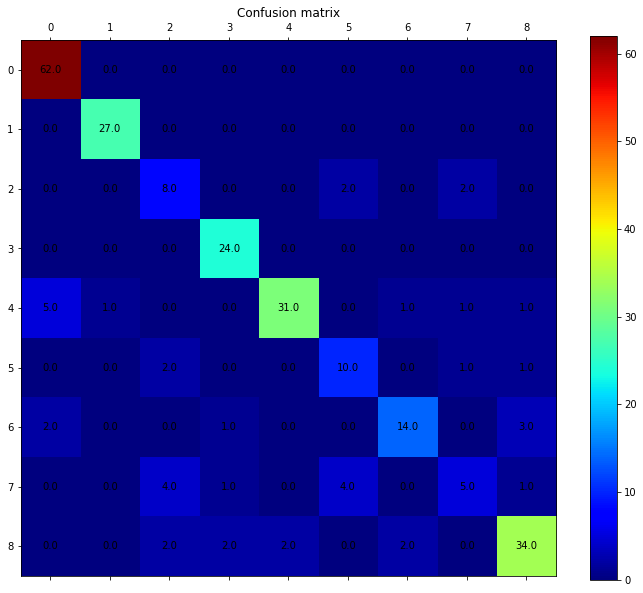

In [23]:
# Mostramos los resultados
fig_conf_matr_cnn_epochs, ax = plt.subplots()
showTestResults(net, ax)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida par el perceptrón muticapa y la red neuronal convolucional. Observar qué sucede al incrementar la cantidad de épocas de entrenamiento.


# Respuestas
1. Implementado en el código de las celdas anteriores. A destacar, en la CNN se ajustan los paddings para mantener los tamaños y así no tener que lidiar con max_pooling sobre tamaños impares.


2. En la siguiente celda se muestra la red implementada en PyTorch. Luego de cada paso del forward se indican los tamaños de los tensores.

In [24]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(
            3, 6, 3, padding=1
        )  # ks=3 y padding=1 mantiene el tamaño
        self.conv2 = nn.Conv2d(
            6, 16, 3, padding=1
        )  # ks=3 y padding=1 mantiene el tamañ
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)  # batch_size x 6 x 28 x 28
        x = F.relu(x)  # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 6 x 14 x 14
        x = self.conv2(x)  # batch_size x 16 x 14 x14
        x = F.relu(x)  # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 16 x 7 x 7
        x = x.view(x.size(0), -1)  # batch_size x 16*7*7
        x = self.fc1(x)  # batch_size x 120
        x = self.fc2(x)  # batch_size x 84
        x = self.fc3(x)  # batch_size x 9
        return x

3. Entrenando por 5 épocas se tienen las siguientes accuracys para el MLP y CNN sobre test:


| Arquitectura 	| Acc Test 	|
|--------------	|----------	|
| MLP          	| 0.60     	|
| CNN          	| 0.79     	|


Se aprecia una notoria mejora en la ACC de la CNN respecto al MLP.




Al entrenar por 50 épocas ambas arquitectura, las accuracys obtenidas sobre test son:


| Arquitectura 	| Acc Test 	|
|--------------	|----------	|
| MLP          	| 0.58     	|
| CNN          	| 0.73     	|


Se aprecia que las accuracys disminuyen en ambos casos. Esto se debe al efecto del overfitting. Lo que ocurrió es que con 5 épocas ambos modelos ya aprendieron todo lo posible de los datos, y en caso de continuar el entrenamiento lo que sucede es que comienzan a memorizar los datos de train.


Para corroborar lo anterior se muestran las curvas de evolución del acc durante el entrenamiento de ambos modelos al entrenar durante 50 épocas.

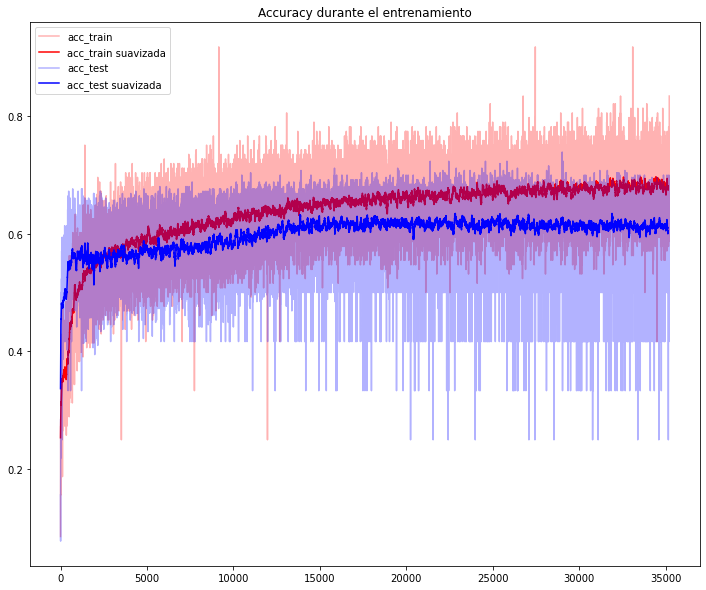

In [25]:
fig_acc_mlp_epochs.patch.set_color("white")
fig_acc_mlp_epochs

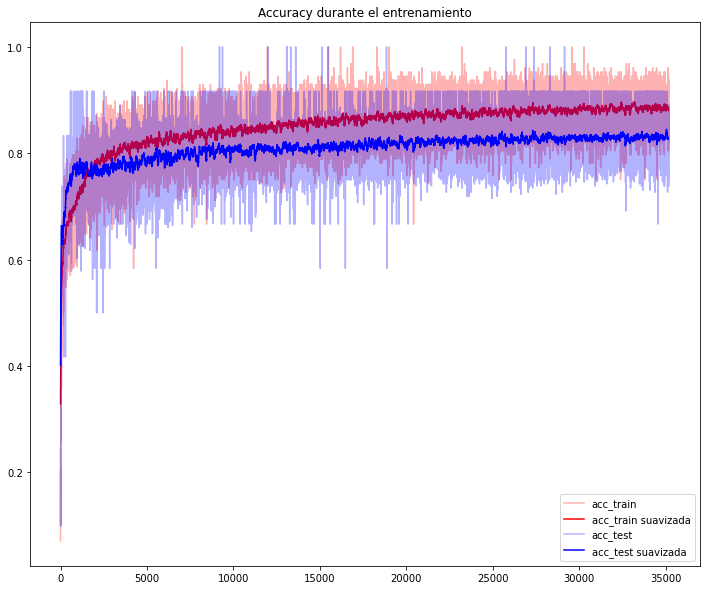

In [26]:
fig_acc_cnn_epochs.patch.set_color("white")
fig_acc_cnn_epochs

En las figuras anteriores se corrobora que en las primeras épocas de entrenamiento la acc de train y test suben a la par. Llegado determinado punto, la acc de test deja de subir, estacándose e incluso disminuyendo un poco; mientras que la acc de train continúa subiendo. Formas de resolver lo anterior es aplicar técnicas como lo son early stopping, que frenan el entrenamiento cuando una métrica objetivo de validación deja de crecer.


En conclusión, se observa que las CNN se desempeñan mejor que los MLP (casi $20\%$ mas de acc). Además, el entrenar indefinidamente no es beneficioso porque conduce al overfitting.